# Fetching crypto and tweets data.

In [1]:
from sklearn.preprocessing import OrdinalEncoder
from crypto_api import CryptoApi
import pandas as pd
import numpy as np
import re


btc_df = pd.read_csv(r'Data\btc_data.csv',usecols=lambda x: x != "Unnamed: 0")

# Analysis of tweets

In [2]:
'''
TODO: GENERAL DATA TASKS:
0) find a way to deal with multiple tweets for a day
1) merge 2 datasets into 
2) imput missing data, maybe try interpolation or expectation maximization
    2.1) compare with mean, median imput methods
3) ivestigate relationship within data, maybe correlation matrix etc
'''

tweets_df = pd.read_csv(r'Data/elon_tweets.csv', index_col=0)
tweets_df['date'] = pd.to_datetime(tweets_df['date'])
                                                
tweets_df = (tweets_df
             .dropna(axis=1, how='all')
             .drop(['vibe','cashtags'], axis=1)) # 1 and 18 notna values respectively  

## Dealing with sparse columns

In [3]:
sparse_cols = tweets_df.columns[tweets_df.notnull().mean() < 1.0].values.copy()

mod_tweets_df = tweets_df.copy()
mod_tweets_df = (mod_tweets_df[mod_tweets_df['lang']=='en']
                 .drop(['id','url','source','sourceUrl'], axis=1)                 
                 .reset_index(drop=True)
                 .copy())

mod_tweets_df = mod_tweets_df.drop(['lang'], axis=1)

## Data cleaning and preprocessing

In [4]:
encoder = OrdinalEncoder()
mod_tweets_df['sourceLabel_encoded'] = encoder.fit_transform(mod_tweets_df['sourceLabel'].values.reshape(-1, 1))
mod_tweets_df['isReplied']   = [0 if type(tweet)==float else 1 for tweet in mod_tweets_df['inReplyToUser']]
mod_tweets_df['isMentioned'] = [0 if type(tweet)==float else 1 for tweet in mod_tweets_df['mentionedUsers']]

#mod_tweets_df = mod_tweets_df.drop(['sourceLabel','inReplyToUser','mentionedUsers'], axis=1)


def extract_dict(line: str, prepare_to_df: False):
    """Extracts data from a dict represented as string and makes it a dict.

    ## Parameters:
        line (str): row of a Series/DataFrame to be preprocessed.
        prepare_to_df (bool): prepares extracted dict to be wrapped into DataFrame.

    ## Returns:
        dict: extracted dict from string.
    """    

    extracted_content = dict(re.findall(r"'(\w+)': '?({.*}|datetime.datetime\(.*\)|[\w\d/:\. ]*)'?", line))
    
    # Wraps dict values into lists to be easily represented as a DataFrame row.
    if prepare_to_df:
        for key,value in extracted_content.items():
            if value == '':
                extracted_content[key] = [None]
            else:
                extracted_content[key] = value
        
    return extracted_content


new_df = mod_tweets_df.copy()     
extracted_df = (pd.DataFrame([*mod_tweets_df['user']
                              .apply(lambda x: extract_dict(x, True))])
                )

new_df = (pd.concat([new_df, extracted_df], axis=1)
            .drop(['user','username','id','displayname','verified','created',
                    'location','protected','profileImageUrl','profileBannerUrl',
                    'rawDescription','renderedDescription','favouritesCount',
                    'friendsCount','mediaCount','statusesCount'], axis=1))

In [5]:
# Converting columns containing numbers to int after extraction.
for column in new_df:
    if 'Count' in column:
        new_df[column] = new_df[column].astype('Int64').copy()

In [6]:
new_df[['rawContent','isReplied','isMentioned']].query("rawContent.str.contains('@')")

new_df['mentionsCount'] = new_df['rawContent'].str.count(r'@[\w\d]+')

In [7]:
new_df['mentions'] = new_df['rawContent'].apply(lambda x : re.findall(r'(@[^\s]+)', x))

count = 0
for a,b in new_df[['mentionsCount','mentions']].values:
    if a==len(b):
        count +=1 
print(count==len(new_df))

True


In [8]:
new_df['charCount'] = new_df['rawContent'].apply(lambda x: len(x))
new_df = new_df.drop('descriptionLinks', axis=1)

In [9]:
#links = tweets_df[tweets_df.columns[tweets_df.columns.isin(new_df.columns)==False]]['links'].value_counts().copy()

tweets_df[tweets_df['rawContent']=='True']['quotedTweet'].iloc[0]

'{\'url\': \'https://twitter.com/ggreenwald/status/1625871270737809408\', \'date\': datetime.datetime(2023, 2, 15, 14, 54, 52, tzinfo=datetime.timezone.utc), \'rawContent\': "The corporate media\'s ability to -- overnight -- turn anyone who dissents in anyway into some sort of fascist or even Hitler-like figure, and then have millions of their followers go around mindlessly repeating it, is both impressive and chilling:", \'renderedContent\': "The corporate media\'s ability to -- overnight -- turn anyone who dissents in anyway into some sort of fascist or even Hitler-like figure, and then have millions of their followers go around mindlessly repeating it, is both impressive and chilling:", \'id\': 1625871270737809408, \'user\': {\'username\': \'ggreenwald\', \'id\': 16076032, \'displayname\': \'Glenn Greenwald\', \'rawDescription\': \'Journalist; Author; Host, @SystemUpdate_; Columnist, @Folha; Co-Founder: The Intercept, @TheInterceptBr; @abrigo_hope, @FreedomofPress, @ongcriadefavela.

# Model Bulding

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import spacy

nlp = spacy.load('en_core_web_sm')

url_pattern = [{"label": "URL", 
                "pattern": [{"LIKE_URL": True}]},
               {"label": "TAG", 
                "pattern": [{"TEXT": {"REGEX": "@\w+"}}]}]

ruler = nlp.add_pipe('entity_ruler', before='ner')
ruler.add_patterns(url_pattern)

corpus = []
for doc in nlp.pipe(new_df['rawContent'], batch_size=1000, n_process=4):
    tokens = []
    for token in doc:
        if not token.is_stop and (token.is_alpha or token.ent_type_=='TAG'):
            tokens.append(token.lemma_)
            
    corpus.append(' '.join(tokens))

train_data = corpus.copy()

In [11]:
# Vectorize the documents with TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorized_docs = vectorizer.fit_transform(train_data)

# Train the LDA model
lda = LatentDirichletAllocation(n_components=3, random_state=1, verbose=True, learning_method='online', n_jobs=4, batch_size=128*30)
lda.fit(vectorized_docs)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=3840, learning_method='online',
                          n_components=3, n_jobs=4, random_state=1,
                          verbose=True)

In [12]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        for i in topic.argsort()[:-top_n - 1:-1]:
            print(f'   {vectorizer.get_feature_names_out()[i]:<15}- {round(topic[i], 2)}')
        print()
        
# Keywords for topics clustered by Latent Dirichlet Allocation
selected_topics(lda, vectorizer, 5)

Topic 0:
   great          - 69.97
   good           - 53.01
   rainmaker1973  - 42.34
   amp            - 40.83
   say            - 37.21

Topic 1:
   yeah           - 75.04
   billym2k       - 66.33
   good           - 54.97
   absolutely     - 54.76
   cool           - 47.38

Topic 2:
   tesla          - 257.21
   amp            - 247.92
   spacex         - 149.56
   wholemarsblog  - 127.66
   teslaownerssv  - 122.1



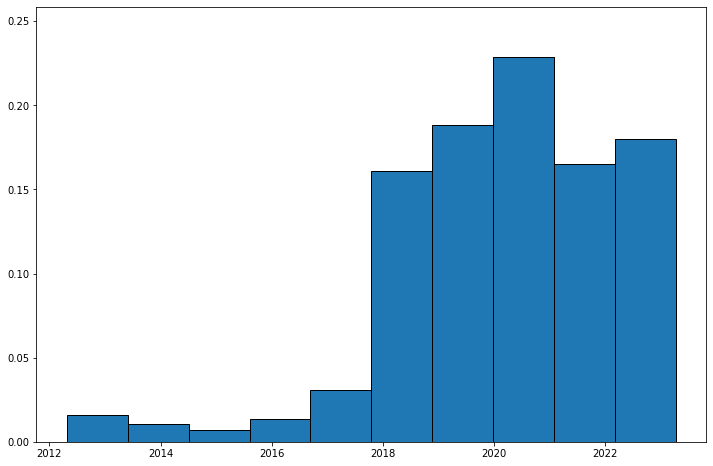

In [13]:
# What does 'amp' mean and is it significant?

import matplotlib.pyplot as plt

dates = []
docs = []
for i, doc in enumerate(train_data):
    if ' amp ' in doc:
        dates.append(new_df['date'].iloc[i])
        docs.append(1)

final_data = pd.DataFrame(zip(dates, docs))

plt.figure(figsize=(12,8))
a,b,c = plt.hist(final_data.iloc[:,0], weights=np.ones(len(final_data))/len(final_data), edgecolor='black')
plt.ylim(0, max(a)+0.03)
plt.show()

In [14]:
# Trying to use spaCy entities to preprocess and clean input data better
# Maybe i need only nouns and verbs, or some entities such as tags(make a entity ruler for it).

doc = nlp(train_data[6])

for token in doc:
    #if token.is_stop or token.is_alpha==False:
    if token.pos_:
        print(f'{token.text:<12} -{token.pos_:^8}-{token.tag_:<5}-{spacy.explain(token.tag_)}')

yum          -  INTJ  -UH   -interjection
well         -  INTJ  -UH   -interjection
deep         -  ADV   -RB   -adverb
fried        -  ADJ   -JJ   -adjective (English), other noun-modifier (Chinese)
butter       -  NOUN  -NN   -noun, singular or mass


In [15]:
from gensim import corpora
from gensim.models import ldamodel

gens_nlp = spacy.load('en_core_web_sm')
df = new_df.copy()

def preprocess(text):
    doc = gens_nlp(text)
    return [token.lemma_ for token in doc if token.pos_ == 'NOUN' or token.pos_ == 'VERB']

documents = df['rawContent'].apply(preprocess)

dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]

lda_model = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=25)

for idx, topic in lda_model.print_topics(num_topics=25, num_words=5):
    print(f'Topic: {idx} \nWords: {topic}')

Topic: 0 
Words: 0.067*"point" + 0.051*"party" + 0.045*"release" + 0.043*"move" + 0.042*"change"
Topic: 1 
Words: 0.074*"like" + 0.056*"month" + 0.052*"lot" + 0.031*"check" + 0.025*"return"
Topic: 2 
Words: 0.108*"tweet" + 0.068*"happen" + 0.056*"tell" + 0.042*"hope" + 0.041*"money"
Topic: 3 
Words: 0.111*"say" + 0.083*"have" + 0.037*"start" + 0.035*"concern" + 0.027*"amount"
Topic: 4 
Words: 0.270*"’" + 0.103*"do" + 0.041*"know" + 0.037*"medium" + 0.027*"problem"
Topic: 5 
Words: 0.059*"note" + 0.048*"feel" + 0.043*"world" + 0.036*"base" + 0.035*"understand"
Topic: 6 
Words: 0.132*"work" + 0.037*"team" + 0.031*"demand" + 0.030*"code" + 0.029*"support"
Topic: 7 
Words: 0.173*"make" + 0.058*"agree" + 0.056*"life" + 0.044*"reality" + 0.031*"term"
Topic: 8 
Words: 0.061*"keep" + 0.050*"use" + 0.039*"government" + 0.039*"die" + 0.036*"live"
Topic: 9 
Words: 0.079*"thing" + 0.053*"case" + 0.037*"energy" + 0.036*"idea" + 0.032*"_"
Topic: 10 
Words: 0.069*"question" + 0.042*"buy" + 0.040*"orb